In [54]:
import pandas as pd

data = pd.read_csv('reviews.csv')
data.head(5)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify ... why do I get songs that I di...,1,1,NaN


In [55]:
data.iloc[4,1]

"Dear Spotify ...  why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?"

In [56]:
data.isnull().sum()

Time_submitted        0
Review                0
Rating                0
Total_thumbsup        0
Reply             61378
dtype: int64

In [57]:
data.drop(['Time_submitted', 'Reply'], axis=1, inplace=True)

In [58]:
data.isnull().sum()

Review            0
Rating            0
Total_thumbsup    0
dtype: int64

<AxesSubplot: xlabel='Rating', ylabel='count'>

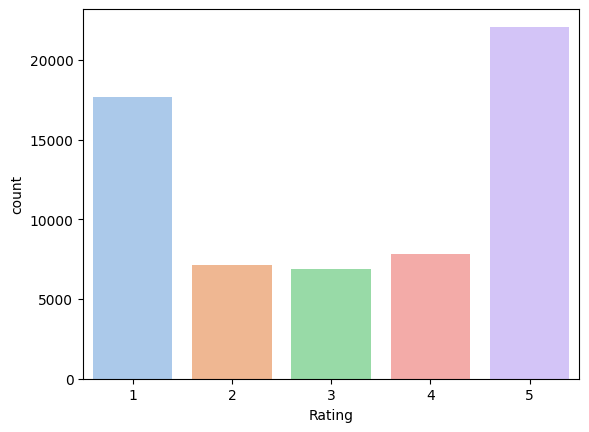

In [59]:
import seaborn as sns

sns.countplot(x='Rating', data=data, palette='pastel')

In [60]:
def transform_ratings(rating):
    if rating == 5 or rating == 4:
        return "Good"
    if rating == 3:
        return "Neutral"
    if rating == 2 or rating == 1:
        return "Bad"

,Review,Rating,Total_thumbsup,Desc,length
0,"Great music service, the audio is high quality...",5,2,Good,112
1,Please ignore previous negative rating. This a...,5,1,Good,86
2,"This pop-up ""Get the best Spotify experience o...",4,0,Good,106
3,Really buggy and terrible to use as of recently,1,1,Bad,47
4,Dear Spotify ... why do I get songs that I di...,1,1,Bad,105


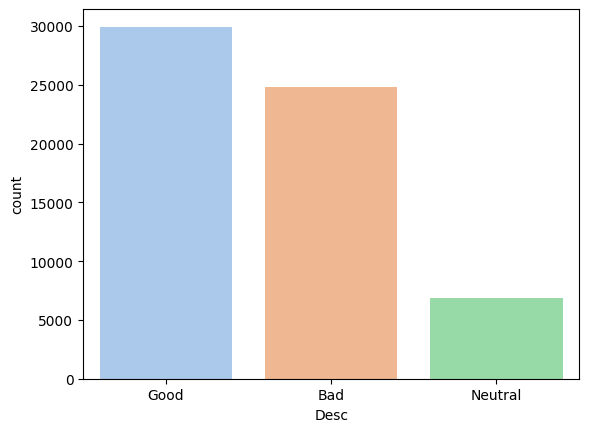

In [61]:
data['Desc'] = data['Rating'].apply(transform_ratings)
data['length'] = data['Review'].str.len()
sns.countplot(x='Desc', data=data, palette='pastel')
data.head()

<AxesSubplot: xlabel='length', ylabel='Total_thumbsup'>

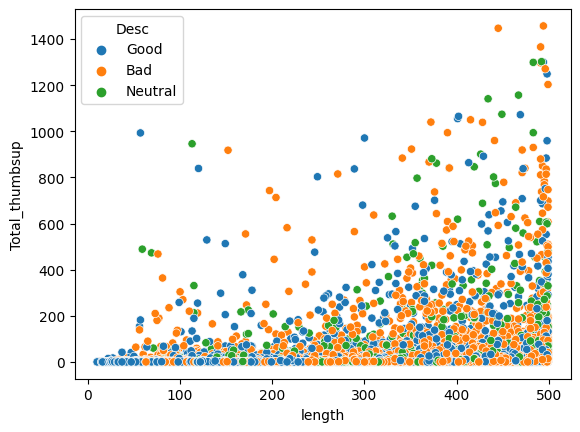

In [62]:
sns.scatterplot(x=data['length'][data.length < 500], y=data['Total_thumbsup'][data.Total_thumbsup < 1500], hue=data['Desc'])

In [63]:
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data.head()["Review"]

0    great music service, the audio is high quality...
1    please ignore previous negative rating. this a...
2    this pop-up "get the best spotify experience o...
3      really buggy and terrible to use as of recently
4    dear spotify ... why do i get songs that i did...
Name: Review, dtype: object

In [64]:
import re
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: re.sub('[^a-z A-Z 0-9-]+', '', word))
data.head()["Review"]


0    great music service the audio is high quality ...
1    please ignore previous negative rating this ap...
2    this pop-up get the best spotify experience on...
3      really buggy and terrible to use as of recently
4    dear spotify  why do i get songs that i didnt ...
Name: Review, dtype: object

In [65]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(word for word in word.split() if word not in stop_words))
data.head()["Review"]

0    great music service audio high quality app eas...
1    please ignore previous negative rating app sup...
2    pop-up get best spotify experience android 12 ...
3                   really buggy terrible use recently
4    dear spotify get songs didnt put playlist shuf...
Name: Review, dtype: object

In [66]:
from nltk.stem import WordNetLemmatizer
lemmat = WordNetLemmatizer()
data.loc[:,'Review'] = data.loc[:,'Review'].apply(lambda word: " ".join(lemmat.lemmatize(word) for word in word.split()))
data.head()["Review"]

0    great music service audio high quality app eas...
1    please ignore previous negative rating app sup...
2    pop-up get best spotify experience android 12 ...
3                   really buggy terrible use recently
4    dear spotify get song didnt put playlist shuff...
Name: Review, dtype: object

In [92]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report



X = data['Review'].head(5000)
y = data['Desc'].head(5000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3750,), (1250,), (3750,), (1250,))

In [93]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [94]:
cv = CountVectorizer()
cv.fit(X_train)
X_train_count = cv.transform(X_train)
X_test_count = cv.transform(X_test)


In [95]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2,3))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [97]:
rf1 = RandomForestClassifier()
rf1.fit(X_train_count, y_train)
rf_cv = rf1.score(X_test_count, y_test)
print(f'Random Forest Classifier on Count Vectors: {rf_cv}')

Random Forest Classifier on Count Vectors: 0.7496


In [98]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_tfidf, y_train)
rf_tfidf = rf2.score(X_test_tfidf, y_test)
print(f'Random Forest Classifier on TF-IDF Vectors: {rf_tfidf}')

Random Forest Classifier on TF-IDF Vectors: 0.7376


In [99]:
# test_reviews = ['This is a great app!', 'Uncomfortable UI, always lagging', 'I like the song selection, but the ads are annoying']
test_reviews = ['This is a great app!', 'Uncomfortable UI, always lagging', 'lagging']
pred = rf1.predict(cv.transform(test_reviews))
pred_transformed = le.inverse_transform(pred).tolist()

In [100]:
result = pd.DataFrame({'Reviews':test_reviews, 
                       'Outcome': pred_transformed})
result

,Reviews,Outcome
0,This is a great app!,Good
1,"Uncomfortable UI, always lagging",Good
2,lagging,Bad
